# Gene Trajectory Python tutorial: Human myeloid #

GeneTrajectory is a method for inferring gene trajectories in scRNA-seq data, which facilitates understanding of gene dynamics underlying biological processes. The major workflow of GeneTrajectory comprises the following four main steps:

- Step 1. Build a cell-cell kNN graph in which each cell is connected to its k-nearest neighbors. Find the shortest path connecting each pair of cells in the graph and denote its length as the graph distance between cells.
- Step 2. Compute pairwise graph-based Wasserstein distance between gene distributions, which quantifies the minimum cost of transporting the distribution of a given gene into the distribution of another gene in the cell graph.
- Step 3. Generate a low-dimensional representation of genes (using Diffusion Map by default) based on the gene-gene Wasserstein distance matrix. Identify gene trajectories in a sequential manner.
- Step 4. Determine the order of genes along each gene trajectory.

![GT_workflow.png](https://github.com/richcmwang/gene-trajectory-experiments/blob/main/docs/notebooks/tutorial_images/GT_workflow.png?raw=1)

In [35]:
!pip install \
igraph>=0.10 \
matplotlib>=3.6 \
numpy>=1.25 \
pandas>=1.5 \
pot>=0.8.2 \
scanpy>=1.9.3 \
scikit-misc>=0.1.3 \
scikit-learn>=0.24 \
scipy>=1.8 \
seaborn>=0.13 \
tqdm>=4.64.1

In [36]:
!pip install ipywidgets>=8.0.0 --upgrade

In [37]:
!git clone https://github.com/richcmwang/gene-trajectory-experiments.git
%cd gene-trajectory-experiments

fatal: destination path 'gene-trajectory-experiments' already exists and is not an empty directory.
/content/gene-trajectory-experiments/gene-trajectory-experiments


In [38]:
import scanpy as sc
from gene_trajectory.add_gene_bin_score import add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding
from gene_trajectory.get_graph_distance import get_graph_distance
from gene_trajectory.gene_distance_shared import cal_ot_mat
from gene_trajectory.run_dm import run_dm
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_umap
from gene_trajectory.util.download_file import download_file_if_missing

from gene_trajectory.widgets import ExtractGeneTrajectoryWidget

In [39]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [40]:
from google.colab import output
output.enable_custom_widget_manager()

## Loading example data  ##
The standard preprocessing can be done by employing the scanpy Python package which includes:
library normalization; finding variable features; scaling; generating PCA embedding (and UMAP embedding for visualization).

We load a preprocessed Scanpy Anndata object where we will perform the gene trajectory inference.

First, we download the data from [figshare](https://figshare.com/articles/dataset/Processed_AnnData_objects_for_GeneTrajectory_inference_Gene_Trajectory_Inference_for_Single-cell_Data_by_Optimal_Transport_Metrics_/25539547), where a copy of the data needed for the tutorial is saved.


In [41]:
download_file_if_missing('tutorial_data/human_myeloid_scanpy_obj.h5ad',
    url='https://figshare.com/ndownloader/files/45448603',
    md5_hash='923f8f00819e9f6401445af8d97275eb',
    create_target_folder_if_missing=True)


File saved on tutorial_data/human_myeloid_scanpy_obj.h5ad


Once the file has been downloaded and saved to `tutorial_data/human_myeloid_scanpy_obj.h5ad`, we load the preprocessed Scanpy Anndata object where we will perform the gene trajectory inference.

In [42]:
adata = sc.read_h5ad('tutorial_data/human_myeloid_scanpy_obj.h5ad')

Review dataset

In [43]:
print(f"cell barcode (ID) x  cell-level features: {adata.var.shape}")
adata.obs   # cell barcode (ID) x  cell-level features

cell barcode (ID) x  cell-level features: (19089, 10)


,orig.ident,nCount_RNA,nFeature_RNA,observed,simulated,percent.mito,RNA_snn_res.0.4,celltype,RNA_snn_res.0.3,seurat_clusters,cluster,GT_score
rna_AAACCCACAGAGTTGG-1,0,5884.0,1836,0.019227,0.101796,0.107580,0,1,0,0,0,1750.110046
rna_AAACGAAAGACGTCGA-1,0,6641.0,2123,0.019608,0.438202,0.113688,0,1,0,0,0,2253.423371
rna_AAACGAAAGGAGTCTG-1,0,12113.0,3479,0.059561,0.664430,0.094361,0,1,1,1,1,4938.157246
rna_AAACGCTAGAGGTTTA-1,0,9052.0,2703,0.030959,0.043587,0.117212,0,1,0,0,0,2331.248993
rna_AAACGCTAGGTTAAAC-1,0,12488.0,3208,0.066214,0.494949,0.080557,0,1,0,0,0,1913.520057
...,...,...,...,...,...,...,...,...,...,...,...,...
rna_TTTGGTTCATAGACTC-1,0,9981.0,2936,0.042619,0.197861,0.127242,0,1,1,1,1,4564.951828
rna_TTTGTTGAGGGCAAGG-1,0,6588.0,2203,0.062755,0.355433,0.088646,0,1,0,0,0,3883.902018
rna_TTTGTTGCATCTGCGG-1,0,2923.0,1157,0.039882,0.051300,0.133425,0,1,0,0,0,1107.366647
rna_TTTGTTGGTCGGTGAA-1,0,10945.0,3109,0.062755,0.392713,0.078483,0,1,1,1,1,5204.868143


The row represents cell ID, and the column represents:

Certainly! Here's the same information in a clean bullet-point list format:

* **`orig.ident`**: Original sample or batch ID (e.g., 0, 1, 2)
* **`nCount_RNA`**: Total number of RNA UMIs (counts) detected in the cell
* **`nFeature_RNA`**: Number of genes detected (non-zero counts)
* **`observed`, `simulated`**: Likely from a modeling step (e.g., diffusion, entropy, or trajectory likelihoods)
* **`percent.mito`**: Percentage of reads from mitochondrial genes (common QC feature)
* **`RNA_snn_res.0.4`**: Clustering labels computed at resolution 0.4 (e.g., from a shared nearest neighbor graph)
* **`seurat_clusters`**: Final clustering assignments (often equivalent to a specific `RNA_snn_res`)
* **`celltype`**: Annotated or inferred cell type label
* **`TrajectoryX_genesY`**: Scores from gene trajectory analysis (e.g., from optimal transport or diffusion methods)
* **...**: Other derived summary statistics or metadata features per cell

In [44]:
print(f"gene x gene level features: {adata.var.shape}")
adata.var # gene x gene level features

gene x gene level features: (19089, 10)


,mean,variance,variance.expected,variance.standardized,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,alra_features
AL627309.1,0.005407,0.005591,0.006066,0.921587,0.007353,0.007914,0.007922,0.999045,0,AL627309.1
AL669831.5,0.062341,0.069064,0.071298,0.968670,0.092525,0.104216,0.102521,1.016535,0,AL669831.5
FAM87B,0.001060,0.001271,0.001126,1.129509,0.002757,0.003364,0.002906,1.157475,1,FAM87B
LINC00115,0.029898,0.032825,0.034802,0.943188,0.040135,0.045278,0.044460,1.018393,0,LINC00115
FAM41C,0.027778,0.028069,0.032381,0.866844,0.036765,0.036037,0.040731,0.884756,0,FAM41C
...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0.006785,0.007588,0.007685,0.987457,0.004289,0.004885,0.004571,1.068783,0,AC011043.1
AL592183.1,0.002226,0.002222,0.002429,0.914541,0.002145,0.002141,0.002243,0.954322,0,AL592183.1
AC007325.4,0.021628,0.022435,0.025309,0.886446,0.039828,0.041319,0.044122,0.936460,0,AC007325.4
AL354822.1,0.026506,0.027502,0.030934,0.889072,0.023284,0.024588,0.025780,0.953751,0,AL354822.1


The gene level features are statistics over the cell population.

* **`mean`**: Mean expression of the gene across all cells (raw or normalized, depending on the pipeline)
* **`variance`**: Variance of expression across all cells
* **`variance.expected`**: Expected variance under a null model (often based on a mean–variance relationship)
* **`variance.standardized`**: Observed variance divided by expected variance — used to score variability
* **`vst.mean`**: Mean expression after **variance-stabilizing transformation (VST)**
* **`vst.variance`**: Variance after VST
* **`vst.variance.expected`**: Expected variance under the VST-based null model
* **`vst.variance.standardized`**: Standardized VST variance = observed / expected
* **`vst.variable`**: Boolean indicating whether the gene is flagged as **highly variable** by the VST method
* **`alra_features`**: Gene identifier or label used during ALRA imputation (if that method was applied)

adata.raw.X:
- matrix of size `cell ID x genes`
- The values are gene counts

adata.X:
- matrix of size `cell ID x genes`
- The values could be normalized and transformed

In [45]:
# cell ID x genes
print(f"Number of cell x Number of genes: {adata.raw.X.shape}")

Number of cell x Number of genes: (3264, 19089)


Next, we add a `cell_type` annotation to the metadata based on the clustering labels and plot it in the UMAP representation.

Original clusters are labeled numerically.

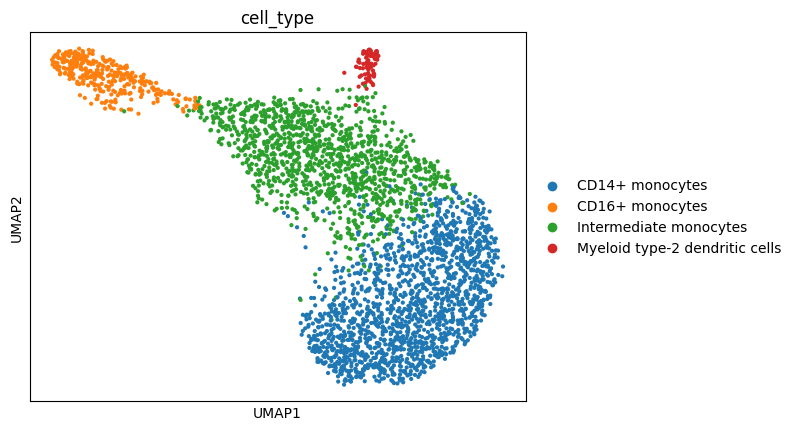

In [46]:
adata.obs['cell_type'] = adata.obs['cluster'].replace({
  0: "CD14+ monocytes",
  1: "Intermediate monocytes",
  2: "CD16+ monocytes",
  3: "Myeloid type-2 dendritic cells"}
)
sc.pl.umap(adata, color=["cell_type"])


How is UMAP calculated in Scanpy?

**Step 1: PCA**

* Compress high-dimensional gene expression into fewer components while preserving structure.
* **Input**: `adata.X` (cells × genes)
* **Output**:
  `adata.obsm["X_pca"]` (cells × PCs)

**Step 2: Compute Neighborhood Graph**

* Build a graph connecting each cell to its nearest neighbors based on PCA space.
* **Input**: `adata.obsm["X_pca"]`
* **Output**:
  `adata.obsp["connectivities"]` → weighted cell-cell similarity graph
  `adata.obsp["distances"]` → raw distances

**Step 3: Compute UMAP Embedding**

* Learn a 2D or 3D layout that preserves local cell neighborhoods.
* **Input**: `adata.obsp["connectivities"]`
* **Output**:
  `adata.obsm["X_umap"]` (cells × 2)


## Gene-gene distance computation ##
We narrow down the gene list for gene-gene distance computation by focusing on the top 500 variable genes expressed by 1% - 50% of cells.



In [47]:
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.raw.X.copy()
genes = select_top_genes(adata, layer='counts', n_variable_genes=500)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [48]:
from google.colab import output
output.disable_custom_widget_manager()

In [49]:
len(genes)

251

## Prepare the input for gene-gene Wasserstein distance computation ##

Next, we construct the cell-cell kNN graph and calculate cell-cell graph distances.

In [50]:
run_dm(adata)
cell_graph_dist = get_graph_distance(adata, k=10)

In [51]:
gene_expression_updated, graph_dist_updated = coarse_grain_adata(adata, graph_dist=cell_graph_dist, features=genes, n=500)

In [52]:
gene_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated,
                           ot_cost=graph_dist_updated,
                           show_progress_bar=True)

100%|██████████| 31375/31375 [03:39<00:00, 143.16it/s]


## Gene trajectory inference and visualization ##

Next, we generate the gene embedding by employing Diffusion Map.

In [53]:
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)

The extraction of gene trajectories is done sequentially. The initial node (terminus-1) is defined by the gene with the largest distance from the origin in the Diffusion Map embedding. A random-walk procedure is then employed on the gene graph to select the other genes that belong to the trajectory terminated at terminus-1. After retrieving genes for the first trajectory, we identify the terminus of the subsequent gene trajectory among the remaining genes and repeat the steps above. This is done iteratively until all detectable trajectories are extracted.

To refine the trajectories we use the widget `ExtractGeneTrajectoryWidget`, which allows to tune parameters. We also label  some genes that are important in the system (e.g. CLEC5A, CD1C, FCGR3A, and PKIB)


In [54]:
extract_gene_trajectory_widget = ExtractGeneTrajectoryWidget(gene_embedding, gene_dist_mat, genes,
                                                             label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])
extract_gene_trajectory_widget

ExtractGeneTrajectoryWidget(children=(VBox(children=(Label(value='Extract gene trajectories options'), IntSlid…

We perform the following changes
- Since this tutorial is made on a small dataset, set `k` from the default of `10` to `5`.
- We slide the values of `t_list` to cover all genes, first extending the `t` for  `Trajectory-2` to 8
- Adjust the `t` for `Trajectory-1` to 4
- Adjust the `t` for `Trajectory-3`, until all genes are cover, i.e. to `7`

The interactive optimization of the parameters is equivalent to setting the parameters
- `k` = `5`
- `t_list` = `[4, 8, 7]`
the same set of parameters could have been applied directly as
```
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, t_list = [4, 8, 7], gene_names=genes, k=5)
plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])
```

Next, we extract the gene trajectory from the widget:

In [55]:
gene_trajectory = extract_gene_trajectory_widget.gene_trajectory

In [58]:
gene_trajectory

,DM_1,DM_2,DM_3,DM_4,DM_5,selected,Pseudoorder-1,Pseudoorder-2
LYPD2,0.097112,-0.030811,-0.053331,0.055690,-0.030806,Trajectory-1,196.0,0.0
FCGR3A,0.060951,-0.002756,0.010743,-0.021936,0.022453,Trajectory-1,183.0,0.0
FCER1A,-0.002819,0.022891,-0.008832,0.003983,-0.015901,Trajectory-1,83.0,0.0
HLA-DQA1,0.000598,0.016596,0.006070,0.000463,-0.017135,Trajectory-1,132.0,0.0
CDKN1C,0.074123,-0.012224,-0.009662,0.001662,0.008045,Trajectory-1,187.0,0.0
...,...,...,...,...,...,...,...,...
DHRS9,-0.002620,0.008196,0.004309,0.005095,-0.009761,Trajectory-1,91.0,0.0
BIRC3,-0.002310,0.004090,0.007353,0.004074,-0.005034,Trajectory-1,104.0,0.0
CLCN4,-0.008302,-0.023901,-0.022154,-0.035206,-0.017195,Trajectory-2,0.0,45.0
ARL4A,-0.004317,-0.001027,0.004257,0.006275,0.001353,Trajectory-1,63.0,0.0


## Visualize gene bin plots ##

To examine how each given gene trajectory is reflected over the cell graph, we can track how these genes are expressed across different regions in the cell embedding.
For generating gene bin plots, we use the smooth expression values that are stored in the `alra` layer, which were computed using [ALRA](https://github.com/KlugerLab/ALRA/blob/master/README.md) imputation.


In [57]:
print(gene_trajectory.columns.tolist())


['DM_1', 'DM_2', 'DM_3', 'DM_4', 'DM_5', 'selected', 'Pseudoorder-1', 'Pseudoorder-2']


In [59]:
add_gene_bin_score(adata, gene_trajectory=gene_trajectory, n_bins=5, trajectories=2, layer='alra')

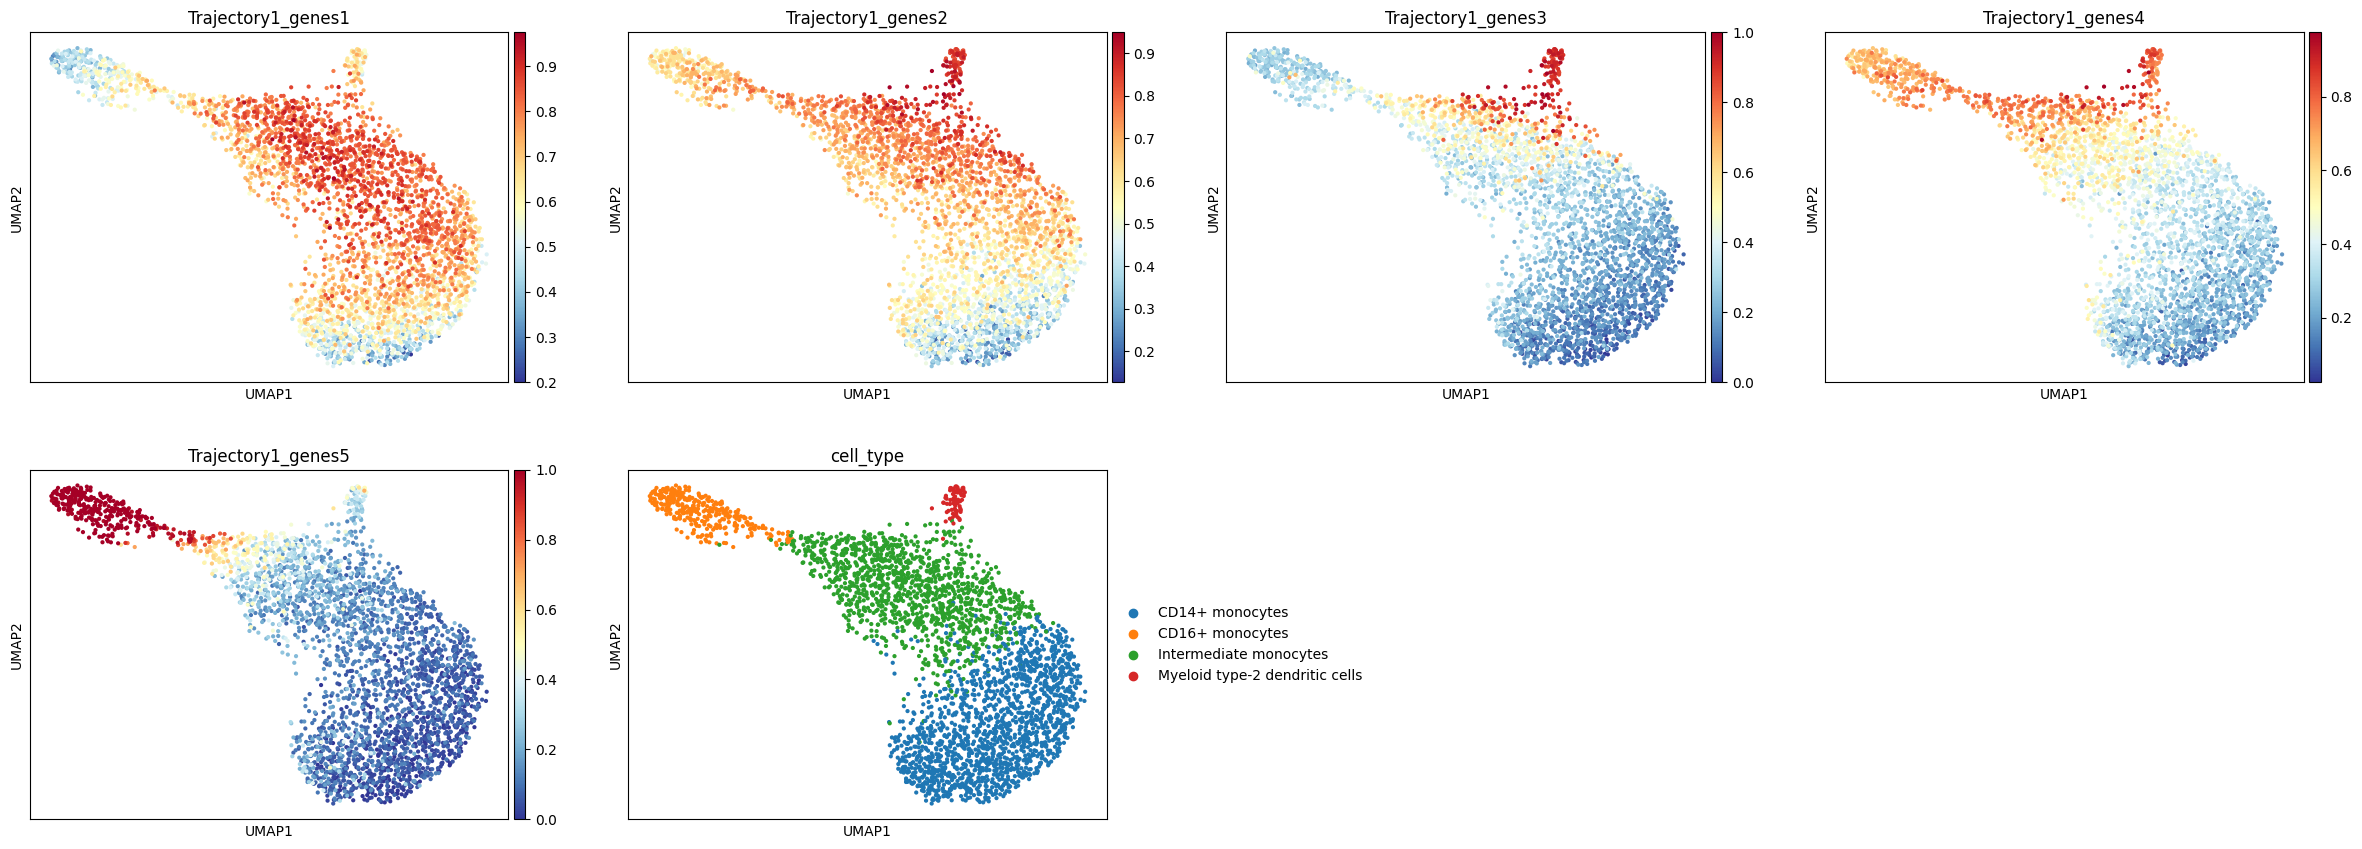

In [60]:
plot_gene_trajectory_umap(adata, 'Trajectory1', other_panels='cell_type')


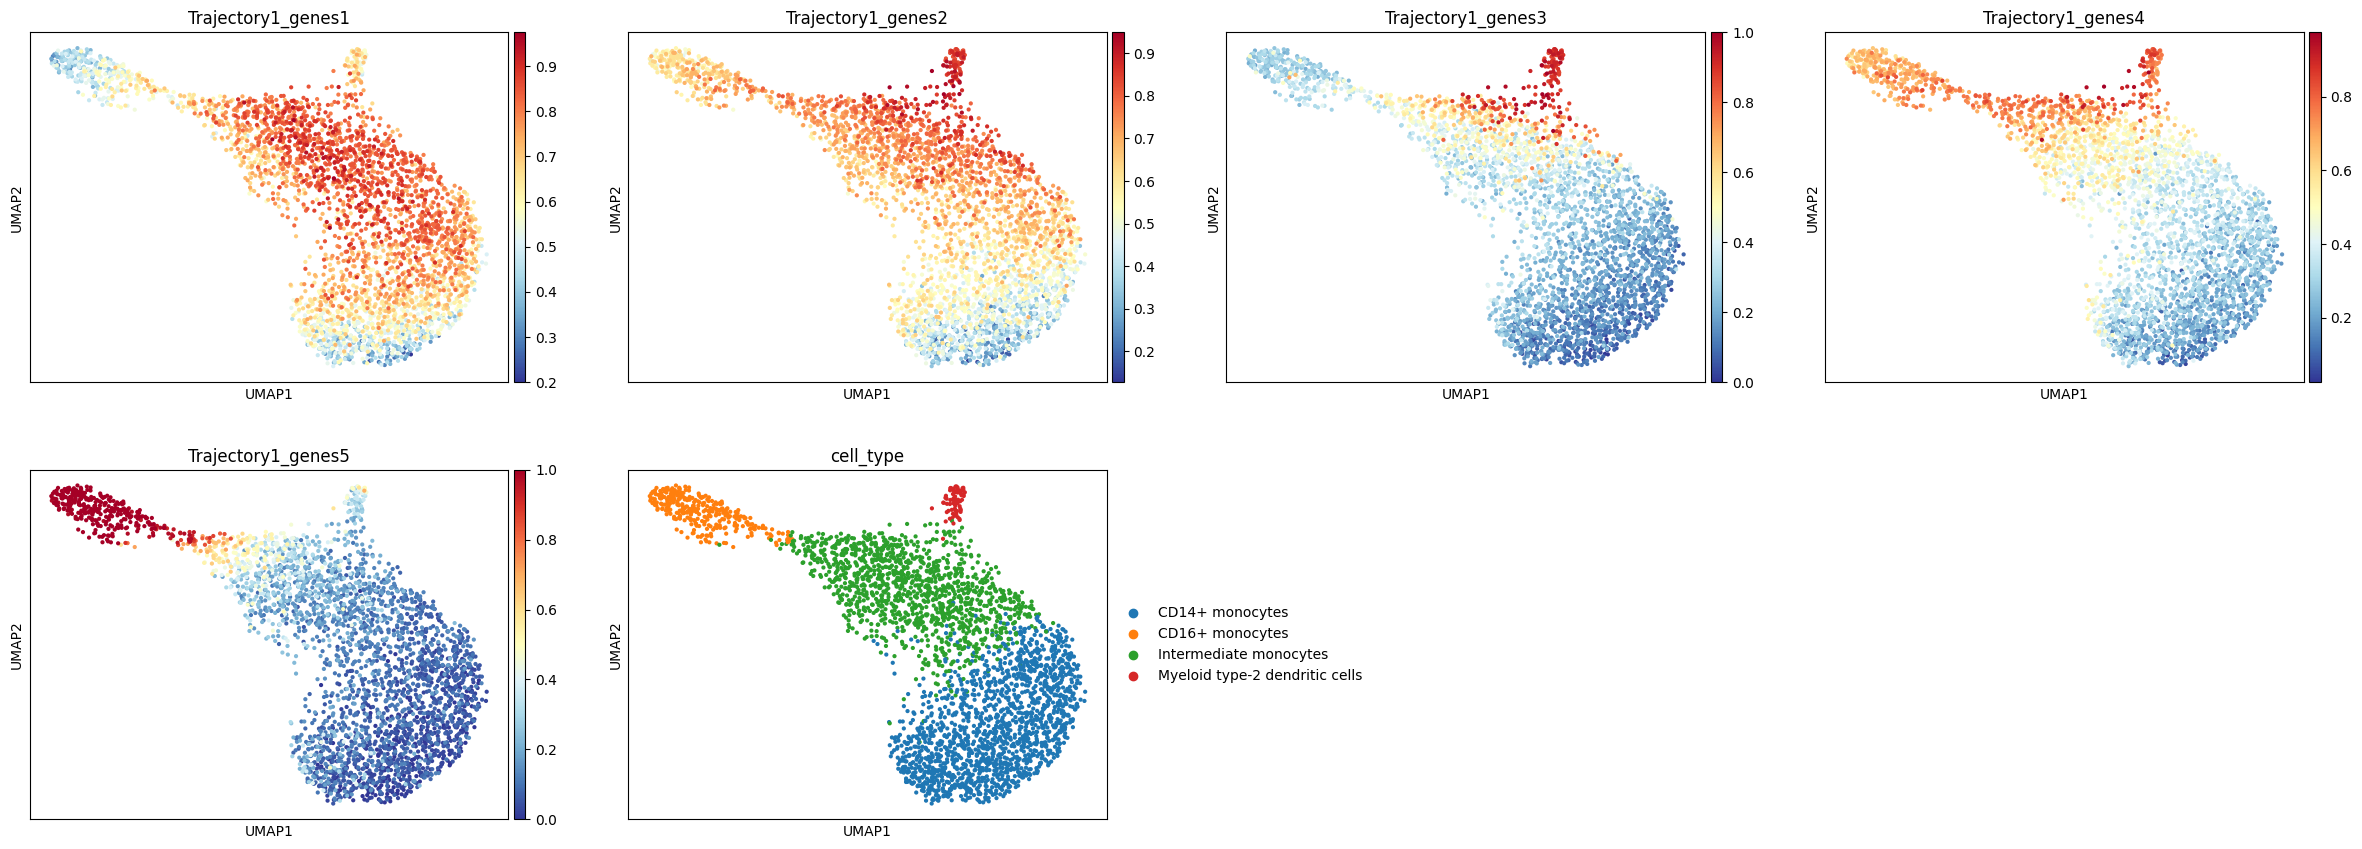

In [61]:
plot_gene_trajectory_umap(adata, 'Trajectory1', other_panels='cell_type')


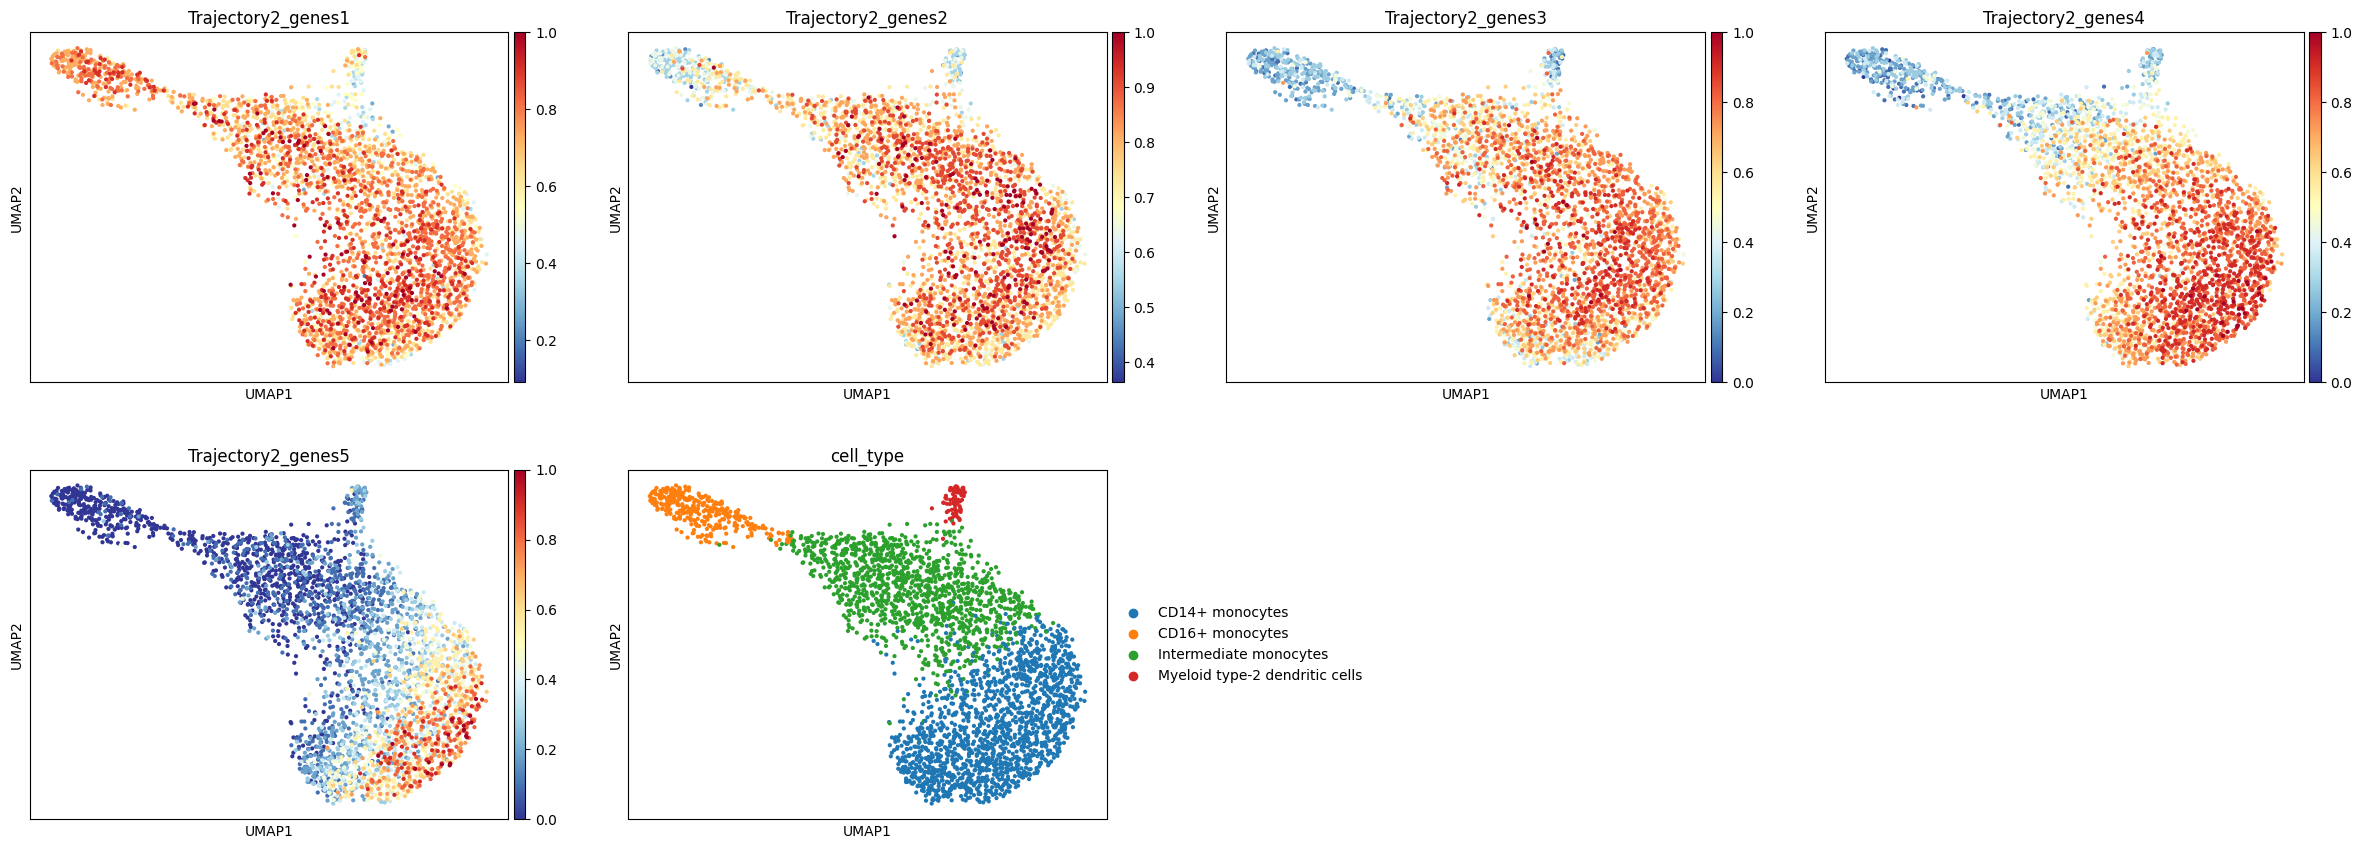

In [62]:
plot_gene_trajectory_umap(adata, 'Trajectory2', other_panels='cell_type')


We plot Trajectory 3 in reverse order as we want the gene `CLEC5A` to be at the end of the trajectory rather than at the beginning

In [63]:
plot_gene_trajectory_umap(adata, 'Trajectory3', other_panels='cell_type', reverse=True)


ValueError: No obj metadata found for Trajectory3